# Analysing AllDC scRNAseq analysis

In [2]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce

In [3]:
#show current directory 
os.getcwd()
os.chdir('/scratch/user/s4436039/sc_AllDC')
os.getcwd()

'/scratch/user/s4436039/sc_AllDC'

In [4]:
sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [5]:
ddl.logging.print_header()

dandelion==0.3.8 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.2 networkx==3.3 scipy==1.14.0


In [5]:
# import AllDC.h5ad
data = sc.read_h5ad('/scratch/user/s4436039/sc_AllDC/AllDC.h5ad')

In [6]:
data

AnnData object with n_obs × n_vars = 81526 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'culture_type'
    var: 'name'

In [7]:
data.obs

nCount_RNA  nFeature_RNA culture_type
AllDC_DL1_AAACCCAAGAAATGGG-1      4643.0          1871    AllDC DL1
AllDC_DL1_AAACCCAAGATTGAGT-1      2458.0          1122    AllDC DL1
AllDC_DL1_AAACCCAAGCGAGGAG-1      9698.0          3014    AllDC DL1
AllDC_DL1_AAACCCAAGCTAATCC-1     25688.0          4973    AllDC DL1
AllDC_DL1_AAACCCAAGCTGACTT-1      2125.0           972    AllDC DL1
...                                  ...           ...          ...
AllDC_OP9_TTTGTTGTCCACGTCT-1     15457.0          3573    AllDC OP9
AllDC_OP9_TTTGTTGTCCATACTT-1      3965.0          1527    AllDC OP9
AllDC_OP9_TTTGTTGTCGCACGAC-1      7444.0          2237    AllDC OP9
AllDC_OP9_TTTGTTGTCGGTAAGG-1      1841.0           988    AllDC OP9
AllDC_OP9_TTTGTTGTCTCTCAAT-1      7144.0          2463    AllDC OP9

[81526 rows x 3 columns]

In [8]:
data.var

name
MIR1302-2HG  MIR1302-2HG
FAM138A          FAM138A
OR4F5              OR4F5
AL627309.1    AL627309.1
AL627309.3    AL627309.3
...                  ...
AC141272.1    AC141272.1
AC023491.2    AC023491.2
AC007325.1    AC007325.1
AC007325.4    AC007325.4
AC007325.2    AC007325.2

[36601 rows x 1 columns]

# Perform QC

In [10]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
data.var["mt"] = data.var_names.str.startswith("MT-")

In [11]:
#calculate QC metrics
sc.pp.calculate_qc_metrics(
    data, qc_vars=["mt"], inplace=True, log1p=True
)

In [12]:
data.obs.columns.tolist()

['nCount_RNA',
 'nFeature_RNA',
 'culture_type',
 'n_genes_by_counts',
 'log1p_n_genes_by_counts',
 'total_counts',
 'log1p_total_counts',
 'pct_counts_in_top_50_genes',
 'pct_counts_in_top_100_genes',
 'pct_counts_in_top_200_genes',
 'pct_counts_in_top_500_genes',
 'total_counts_mt',
 'log1p_total_counts_mt',
 'pct_counts_mt']

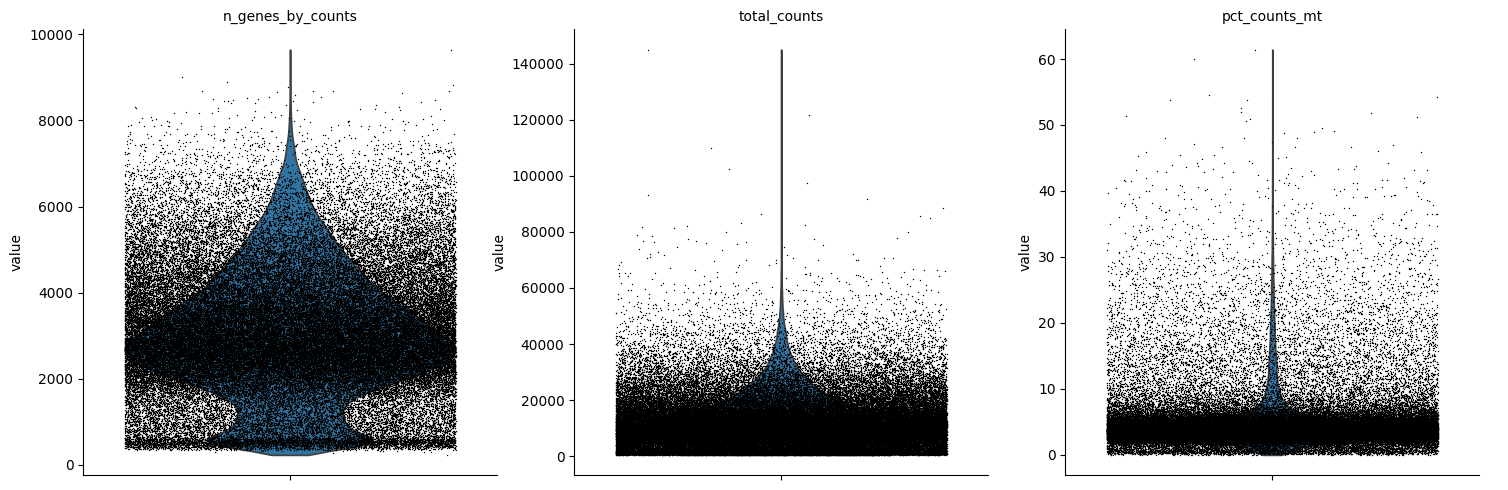

In [13]:
#plot metrics
sc.pl.violin(
    data,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# Normalise and log data: 

In [14]:
#normalise
sc.pp.normalize_total(data, target_sum=1e4)

# Logarithmize the data:
sc.pp.log1p(data)

# check the object
data

AnnData object with n_obs × n_vars = 81526 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'culture_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

# identify hvg, regress, scaling, pca:

In [15]:
# identify hvg
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
data

AnnData object with n_obs × n_vars = 81526 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'culture_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [16]:
#set hidden slot
data.raw = data

In [17]:
#to get number of HV genes
print(data.var.highly_variable.sum())

3135


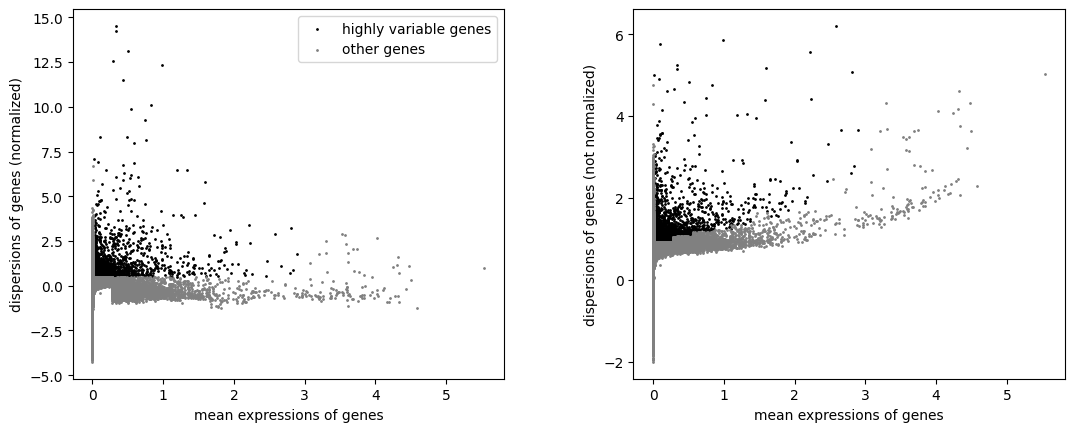

In [18]:
#plot out the number of highly variable genes
sc.pl.highly_variable_genes(data)

## Regress out necessary factors and perform scaling:

In [19]:
# Actually do the filtering for PCA
data = data[
    :, data.var.highly_variable
].copy()  # all rows/indexes : columns only selecting for those within high_variable, and then making a copy of itself
data

AnnData object with n_obs × n_vars = 81526 × 3135
    obs: 'nCount_RNA', 'nFeature_RNA', 'culture_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [20]:
#Regress
sc.pp.regress_out(data, ["total_counts", "pct_counts_mt"])
sc.pp.scale(data, max_value=10)

In [21]:
data

AnnData object with n_obs × n_vars = 81526 × 3135
    obs: 'nCount_RNA', 'nFeature_RNA', 'culture_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## PCA:

In [24]:
## perform PCA, adjust number of PCs to calculate from default (50) to 60. (3mins)
sc.tl.pca(data, n_comps=60)

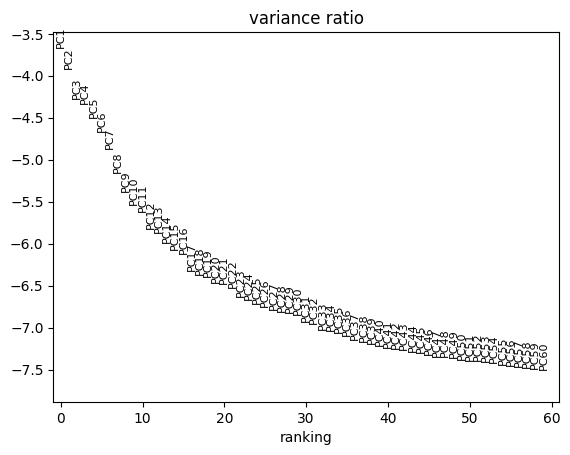

In [25]:
# make elbow plot to see variance contribution by each pc, choose inflection point
sc.pl.pca_variance_ratio(data, log=True, n_pcs=60)

#based on graph choose to use 50 PCs

# neigbourhood graph:

In [26]:
## Computing neighbourhood graph - here UMAP (1min)
sc.pp.neighbors(data, n_neighbors=10, n_pcs=50)

# UMAP:

In [27]:
#Embedding the neighbourhood graph using UMAP 
sc.tl.umap(data, min_dist=0.3)  # 0.3 is personal preference

## Umap visualisation: 

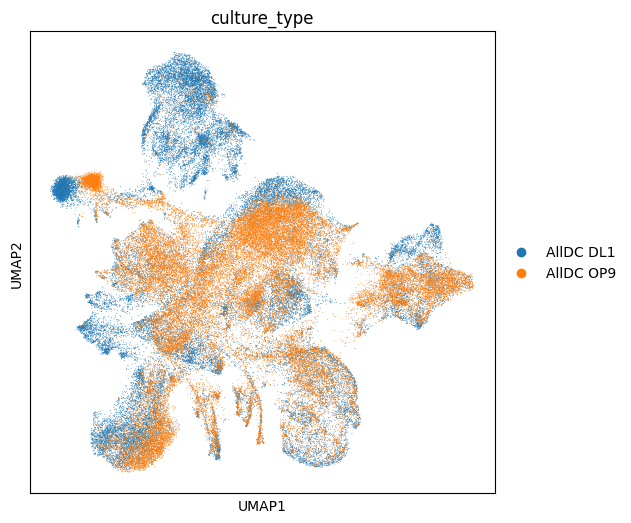

In [7]:
#visualise UMAP
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(
        data,
        color=[
            "culture_type"
        ],
        ncols=1,
    )

# UMAP above suggests I do need to do integration by culture type as looks like they are slightly misaligned

In [6]:
#write out unintegrated object (2min)
#data.write_h5ad("AllDC_unintegrated.h5ad", compression="gzip")
data = sc.read_h5ad('/scratch/user/s4436039/sc_AllDC/AllDC_unintegrated.h5ad')

# Integration: (2min)

In [30]:
sce.pp.harmony_integrate(data, 'culture_type', max_iter_harmony=200, verbose=True)

2025-01-24 09:10:13,578 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-24 09:10:32,815 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-24 09:10:33,110 - harmonypy - INFO - Iteration 1 of 200
2025-01-24 09:11:05,090 - harmonypy - INFO - Iteration 2 of 200
2025-01-24 09:11:36,322 - harmonypy - INFO - Iteration 3 of 200
2025-01-24 09:11:55,827 - harmonypy - INFO - Converged after 3 iterations


In [31]:
# check it worked
data.obsm

AxisArrays with keys: X_pca, X_umap, X_pca_harmony

In [32]:
#assign the new PCs to the standard PCA slot
data.obsm['X_pca'] = data.obsm['X_pca_harmony']

# neigbourhood graph:

In [33]:
## Computing neighbourhood graph - here UMAP 
sc.pp.neighbors(data, n_neighbors=10, n_pcs=50)

# UMAP:

In [34]:
#Embedding the neighbourhood graph using UMAP 
sc.tl.umap(data, min_dist=0.3)  # 0.3 is personal preference

## Umap visualisation: 

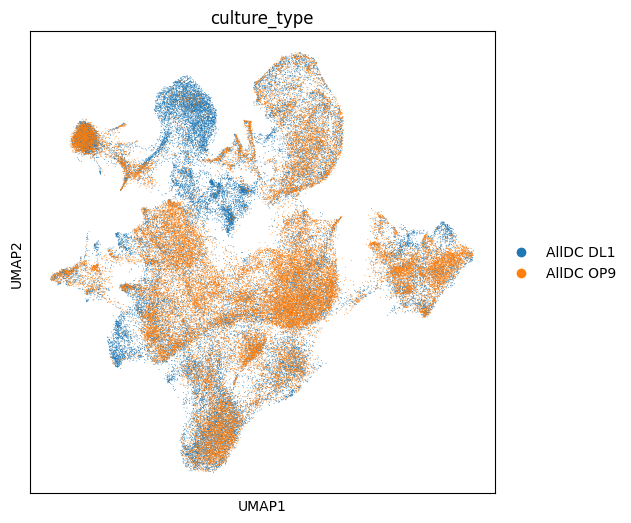

In [35]:
#visualise UMAP
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(
        data,
        color=[
            "culture_type"
        ],
        ncols=1,
    )

In [8]:
#update saved object
#data.write_h5ad("AllDC_integrated.h5ad", compression="gzip")
data = sc.read_h5ad('/scratch/user/s4436039/sc_AllDC/AllDC_integrated.h5ad')

# Cluster data

In [9]:
sc.tl.leiden(data, resolution=0.2, key_added='leiden_0.2')

/scratch/temp/12353491/ipykernel_3891781/2691239739.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


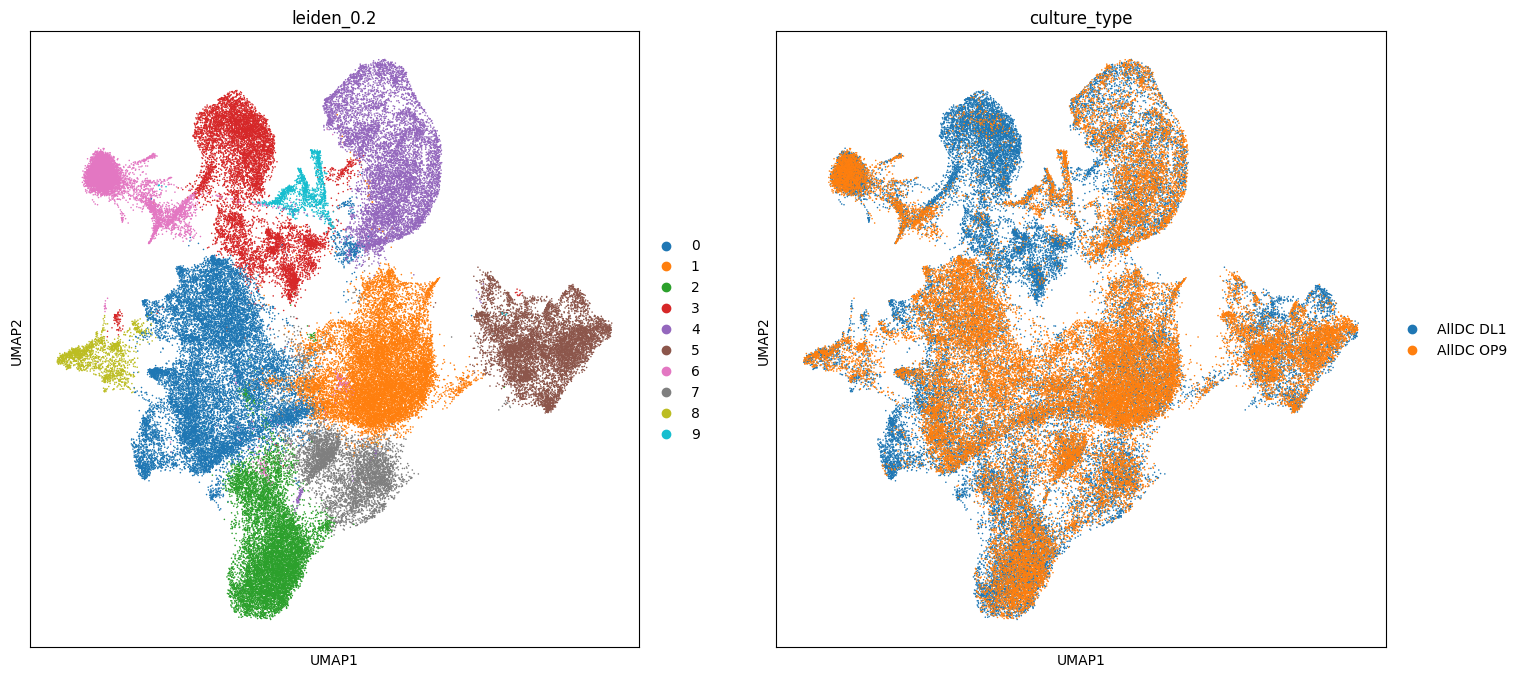

In [10]:
with plt.rc_context({"figure.figsize": (8, 8)}):
    sc.pl.umap(data, color=["leiden_0.2","culture_type"], size=5)

In [41]:
#define function
def cluster_small_multiples(
    data_int, clust_key, size=5, frameon=False, legend_loc=None, **kwargs
):
    tmp = data_int.copy()

    for i, clust in enumerate(data_int.obs[clust_key].cat.categories):
        tmp.obs[clust] = data_int.obs[clust_key].isin([clust]).astype("category")
        tmp.uns[clust + "_colors"] = ["#d3d3d3", data_int.uns[clust_key + "_colors"][i]]

    sc.pl.umap(
        tmp,
        groups=tmp.obs[clust].cat.categories[1:].values,
        color=data_int.obs[clust_key].cat.categories.tolist(),
        size=size,
        frameon=frameon,
        legend_loc=legend_loc,
        **kwargs
    )

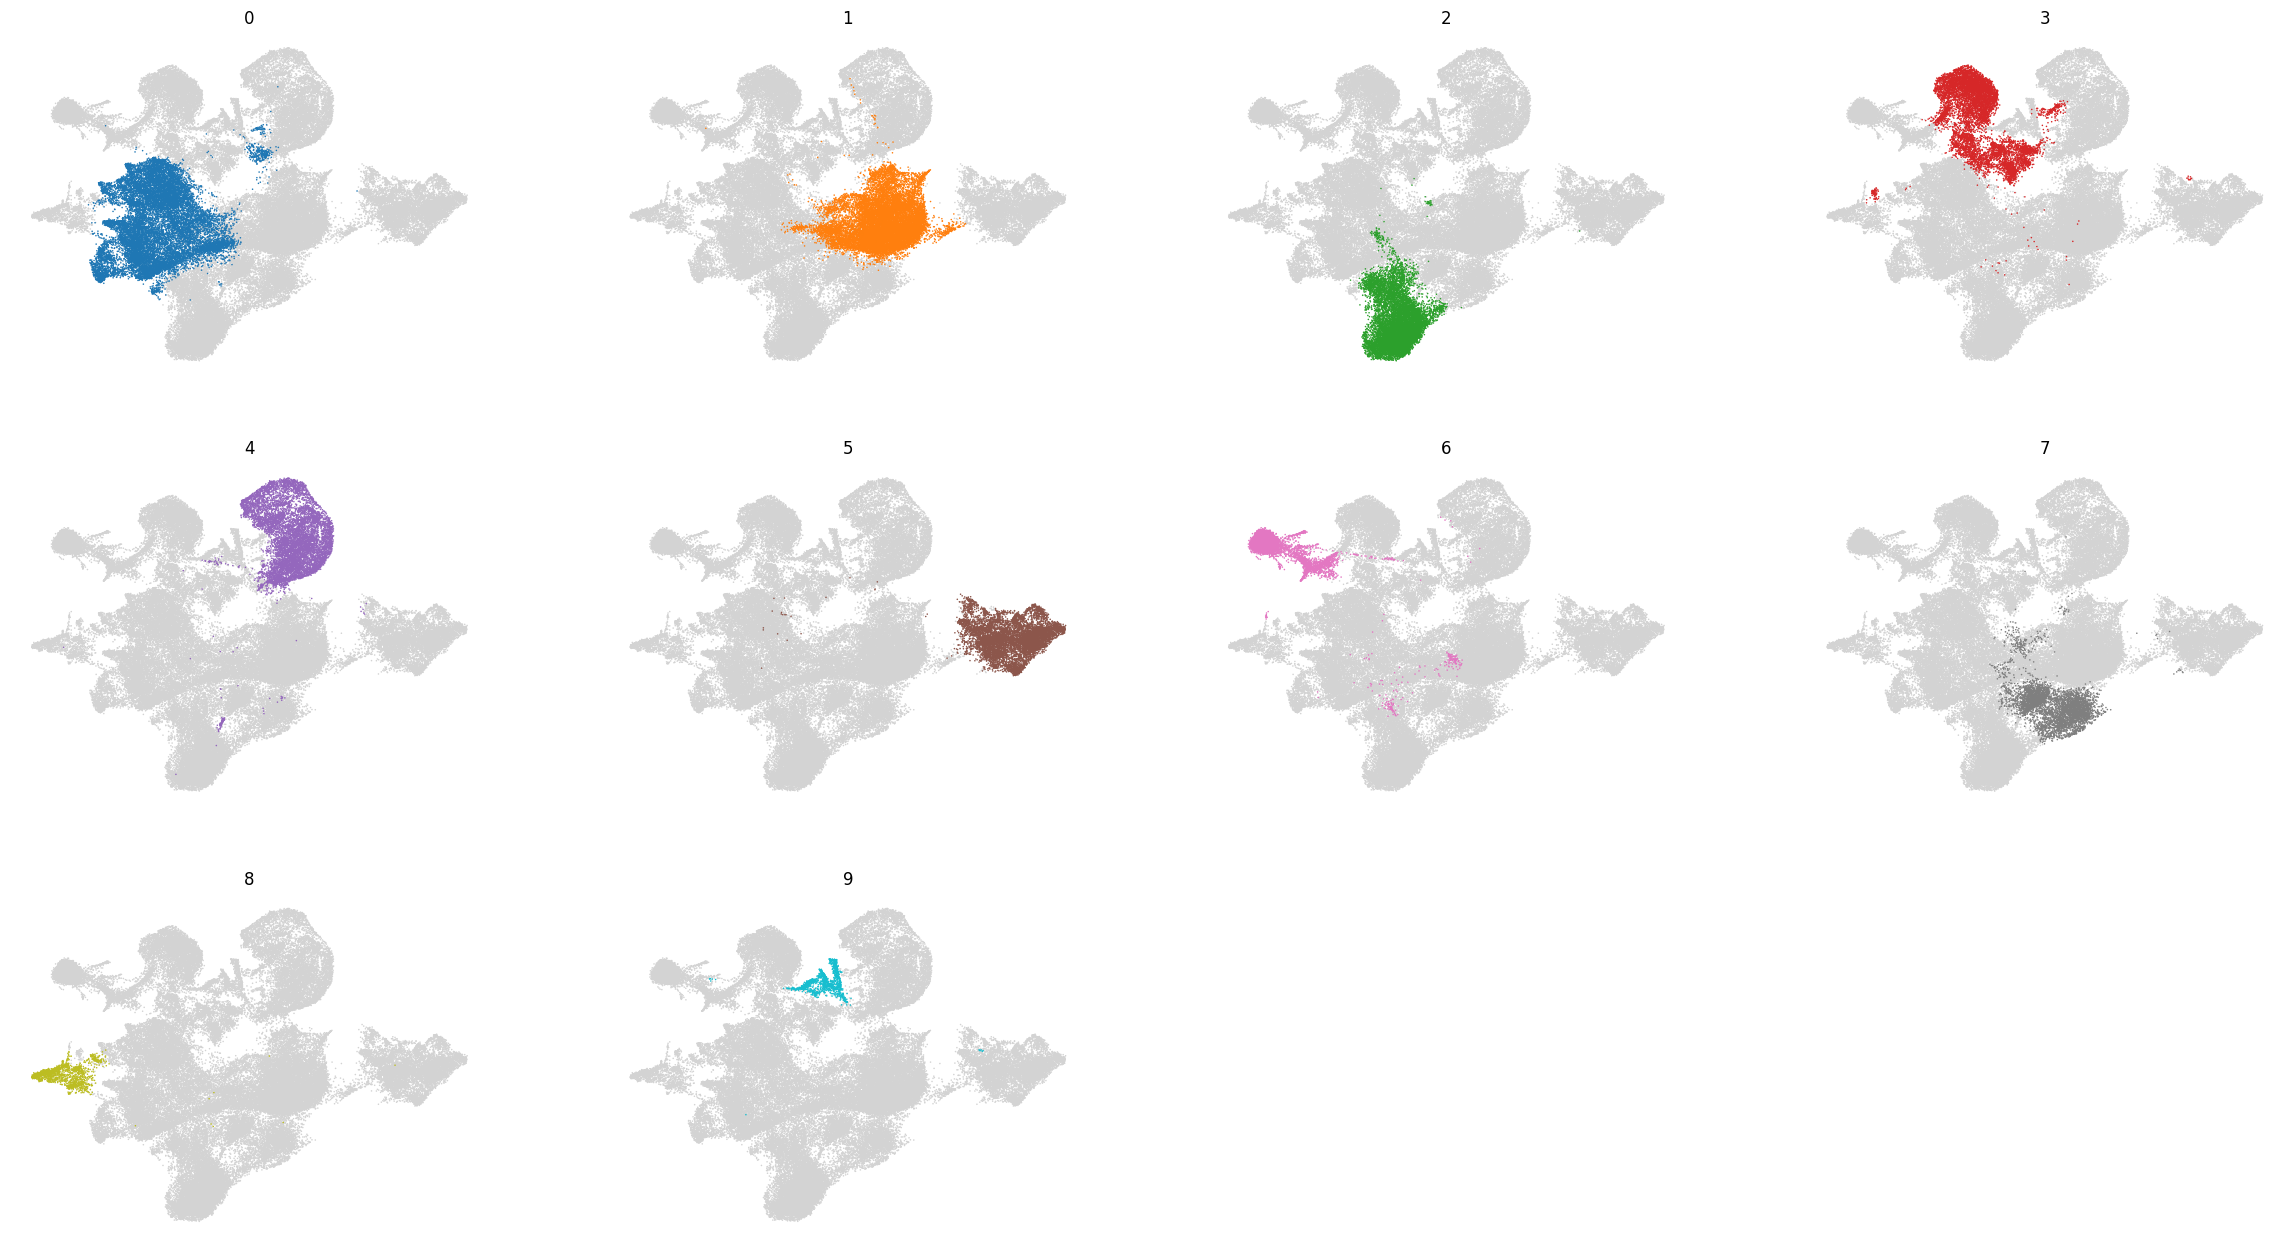

In [42]:
cluster_small_multiples(data, "leiden_0.2")

In [19]:
myeloid_genes = {
    "DC": ["HLA-DRA"],
    "cDC1": ["CLEC9A", "XCR1","BATF3","IRF8"],
    "DC2/DC3": ["CD1C", "FCER1A", "CLEC10A","IRF4"],
    "cDC2": ["CD5"],
    "DC3": ["CD14","CD163","CSF2RA","CSF2RB"],
    "pDC": ["IL3RA","CLEC4C"],
    "progenitors": ["CD33","CD34"],
    "mregDC": ["LAMP3","CD274","CCR7"],
    "Monocytes": ["CD14", "FCGR3A","S100A8","S100A9","CCR2","C5AR1"],
    "Macrophages": ["FCGR1A", "CD68","CSF1R","CX3CR1","AIF1"],
    "Tissue Res Macs": ["C1QA","C1QB","C1QC","BTK"],
    "Proliferating": ["MKI67"]
}

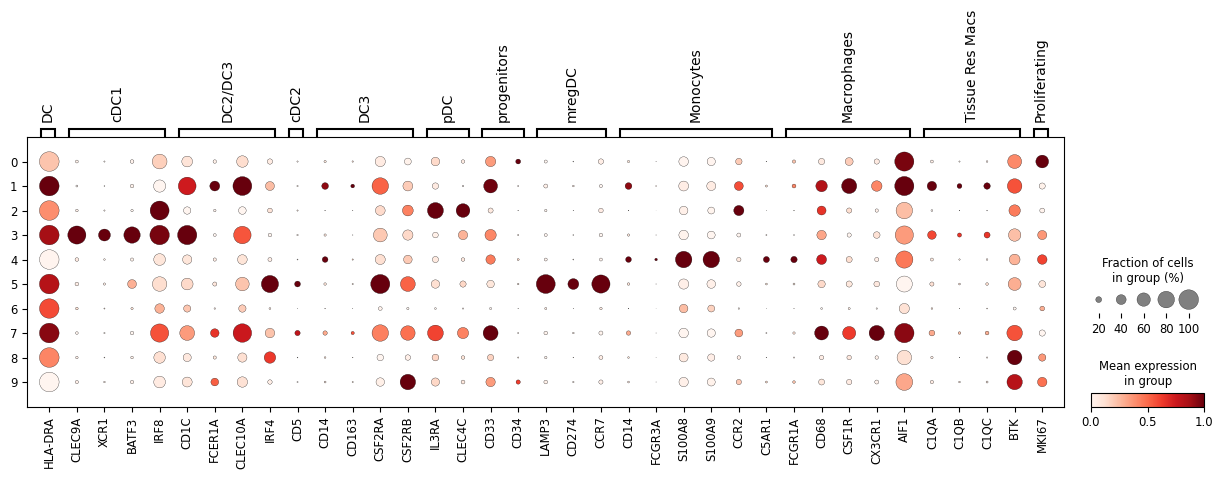

In [20]:
sc.pl.dotplot(data, myeloid_genes, groupby="leiden_0.2", standard_scale="var")

# identify DEG genes: 

In [21]:
#calculate DEG genes:
sc.tl.rank_genes_groups(data, groupby="leiden_0.2", method="wilcoxon")

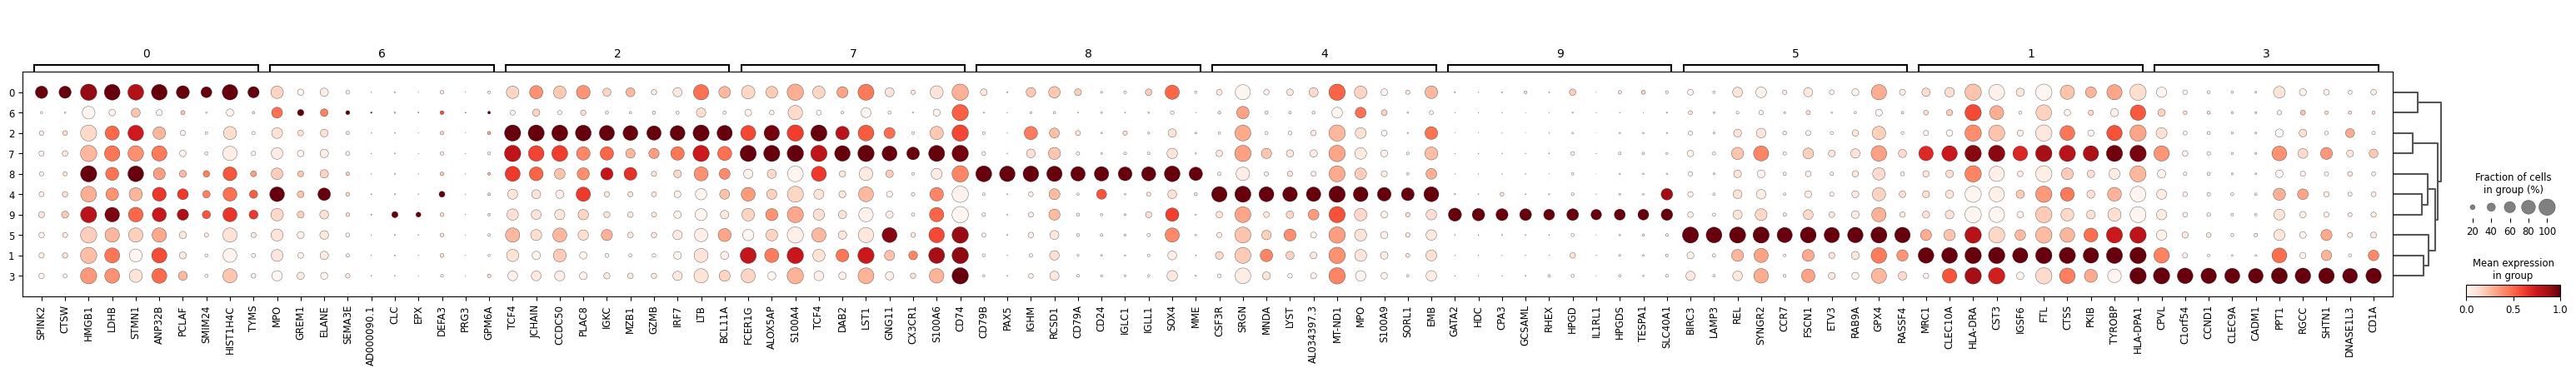

In [32]:
#visualise the top 10 DEG genes for each cluster
sc.pl.rank_genes_groups_dotplot(
    data, groupby="leiden_0.2", standard_scale="var", n_genes=10, min_logfoldchange=1
)

In [24]:
#update saved object
data.write_h5ad("AllDC_integrated.h5ad", compression="gzip")
#data = sc.read_h5ad('/scratch/user/s4436039/sc_AllDC/AllDC_integrated.h5ad')

# score by gene sets:

In [25]:
#define gene sets for Yolk sac derived vs HSC derived macs (from Kelvin)
YS_sig = ['PF4','MMP9','E130306D19RIK','CADM1','IRAK1','SH3YL1','DNAJB6','EPCAM','CHR10:117021051-117038683_F','ECD','PFKP','FABP4','MS4A7','DCAKD','GPS1','TRNAU1AP','AGPAT3','DNAJB6','CHR4:145000941-145148666_F','GPS1','SAE1','FOSB','CHR8:91569369-91594119_R','HOXC4','FOLR2','TUBB2A-PS2','GPS1','CHR8:91569369-91594119_R','BAZ1B','OST4','CHR8:72076364-72077503_R','PTPRA','PLOD1','4930555G01RIK','PHF5A','CHR17:95158347-95160942_F','CHR8:48476637-48492537_F','CHR14:44284425-44300475_F','TC1660977','NMD3','PLAU','BTF3L4','CHR17:33995525-34028025_F','CDK2','FCRLS','1110017F19RIK','MAPK9','GDPD1','CHR2:155269145-155303251_F','FBXO30','TRNAU1AP','MRC1','FAM98B','AV575311','CHR17:95158347-95160942_F','CCDC18','ANLN','CTBP2','ACSM3','S1PR1','PXDN','MAN1A','COX6A1','SLC43A3','CCDC47','FAM178A','TNS3','NAP102625-1','PLEKHG5','NDUFS4','CHR10:14888108-14978308_R','UBE2Z','B3GALNT1','TBC1D19','AK007267','MRTO4','TRAIP','CEP55','CHR10:117021051-117038683_R','CHR10:117021051-117038683_R','UTP20','CHR2:108382077-108441137_R','STMN1','4930534B04RIK','CHR14:44146705-44149729_R','CHR10:117021051-117038683_F','STAB1','SMARCAD1','CHR18:78190463-78235438_R','NAP111768-1','CHR5:121768672-121772658_F','CTSB','MAN2B2','PTN','SLC30A7','LHFPL2','CXCL2','RALGDS','CHR4:133368314-133380210_F','CHR8:19682258-19700836_F','A_55_P2169539','CHR7:99879368-99889978_F','ABCB8','NDRG3','PEG3','NUF2','SENP5','SLC35D1','AI462493','RILPL1','CHR2:108382077-108441137_R','NDUFV1','AHSA1']
HSC_sig = ['TTLL3','FAM55D','6330418K02RIK','GDA','GPR35','IFITM6','XDH','8430419L09RIK','PIRA11','CD74','LOC100038947','MBP','S100A8','GM10693','F12','PID1','A_55_P2184200','CCR2','LILRA6','ETOHI1','PNRC1','ARHGEF37','UBP1','TREML4','VMN1R174','POLR1E','ART2A-PS','CYTIP','TEAD1','KLRA2','GZF1','PLAC8','ENSMUST00000103299','RASGRP4','KLF13','PLBD1','CHR2:128249388-128250301_F','PIRA6','MPG','DENND1C','SMPDL3A','DGKG','ENSMUST00000050386','LIME1','HIST1H2BP','1700112J16RIK','OASL2','PTHLH','AHNAK','CHR3:79069438-79073704_R','A_55_P2050722','KYNU','RAC2','TCTEX1D2','SELL','KLRA9','CHR10:66559716-66647841_R']

#define DC subset gene sets from Villani et al 
DC1_sig = ['CLEC9A','C1ORF54','HLA-DPA1','CADM1','CAMK2D','CPVL','HLA-DPB2','WDFY4','CPNE3','IDO1','HLA-DPB1','LOC645638','HLA-DOB','HLA-DQB1','HLA-DQB','CLNK','CSRP1','SNX3','ZNF366','KIAA1598','NDRG2','ENPP1','RGS10','AX747832','CYB5R3','ID2','XCR1','FAM190A','ASAP1','SLAMF8','CD59','DHRS3','GCET2','FNBP1','TMEM14A','NET1','BTLA','BCL6','FLT3','ADAM28','SLAMF7','BATF3','LGALS2','VAC14','PPA1','APOL3','C1ORF21','CCND1','ANPEP','ELOVL5','NCALD','ACTN1','PIK3CB','HAVCR2','GYPC','TLR10','ASB2','KIF16B','LRRC18','DST','DENND1B','DNASE1L3','SLC24A4','VAV3','THBD','NAV1','GSTM4','TRERF1','B3GNT7','LACC1','LMNA','PTK2','IDO2','MTERFD3','CD93','DPP4','SLC9A9','FCRL6','PDLIM7','CYP2E1','PDE4DIP','LIMA1','CTTNBP2NL','PPM1M','OSBPL3','PLCD1','CD38','EHD4','ACSS2','LOC541471','FUCA1','SNX22','APOL1','DUSP10','FAM160A2','INF2','DUSP2','PALM2','RAB11FIP4','DSE','FAM135A','KCNK6','PPM1H','PAFAH1B3','PDLIM1','TGM2','SCARF1','CD40','STX3','WHAMMP3','PRELID2','PQLC2']
DC2_sig = ['CD1C','FCER1A','CLEC10A','ADAM8','CD1D','FCGR2B','CLEC4A','SLC2A3','CD33','ETS2','CLIC2','PEA15','CACNA2D3','CD1E','MBOAT7','C10ORF128','NR4A2','AGPAT9','ENTPD1','CD2','PER1','PID1','AREG','PTGS1','SMA','CLEC17A','ITGA5','CREB5','PTAFR','NOD2','CCR6']
DC3_sig = ['S100A9','S100A8','VCAN','LYZ','ANXA1','PLBD1','RNASE2','FCER1A','SLC2A3','CD163','CSF3R','MNDA','CD14','NAIP','CSTA','FCN1','CD1D','FPR1','F13A1','CLEC10A','CES1','PID1','S100A12','MTMR11','SMA','LAT2','RETN','TMEM173','AOAH','RAB3D','CD36','MGST1','TREM1','HNMT','CES1P1','ADAM15','IL13RA1','MICAL2','ITGA5','CREB5','IL1B','NR4A2','MPP7','PTAFR','HBEGF','NFE2','ASGR1','BST1','IL1RN','NOD2','NLRP3','DQ575504','LMNA','C9ORF89','IL27RA','NLRP12','RAB27A','EREG','LOC284454']

#mregDC sig from Merad
mregDC_sig = ['CD40','CD80','CD86','RELB','CD83','CD274','PDCD1LG2','CD200','FAS','ALDH1A2','SOCS1','SOCS2','CCR7','MYO1G','CXCL16','ADAM8','ICAM1','FSCN1','MARCKS','MARCKSL1','IL4RA','IL4I1','CCL17','CCL22','TNFRSF4','STAT6','BCL2L1']

#cDC1 derived mregDC vs cDC2 derived mregDC from Cheng
cDC1_mregDC = ['GPR153','SLC2A5','GPR157','PRDM2','PADI2','ECE1','TMEM57','MARCKSL1','MACF1','CDKN2C','TACSTD2','ROR1','IL23R','GADD45A','MCOLN2','RHOC','PPM1J','MAGI3','ATP1A1','FAM46C','ACP6','C1orf54','ENSA','S100A10','DCAF6','RABGAP1L','C1orf21','FAM129A','RGS1','RGS13','TNNT2','LAD1','NAV1','RAB7B','BATF3','CDC42BPA','C1orf198','KIF26B','LINC00298','ID2','GEN1','RAB10','RASGRP3','MAP4K3','MTA3','FOXN2','RTN4','PELI1','LGALSL','AFTPH','PCBP1','TEX261','NEURL3','TBC1D8','MAP4K4','BCL2L11','FOXD4L1','CYTIP','LY75','TANK','TTN-AS1','TTN','ITGA4','PPP1R1C','NABP1','RAPH1','AC079767.4','PIKFYVE','IKZF2','SP140','ATG16L1','RAMP1','FARP2','ING5','IRAK2','THRB','LRRFIP2','PLCD1','OXSR1','RP11-761N21.1','LZTFL1','FLNB','DNASE1L3','LRIG1','FOXP1','ROBO1','CBLB','GCSAM','CD200','BTLA','POGLUT1','PLXNA1','MGLL','SLC9A9','RAP2B','MAP3K13','LPP','CLNK','ARAP2','KLF3','LIMCH1','KIAA1211','RUFY3','GRSF1','MOB1B','G3BP2','PPM1K','TIGD2','DAPP1','H2AFZ','NOCT','IL15','INPP4B','SMARCA5','ZNF827','CASP3','CTD-2231H16.1','CCDC127','OTULIN','ANKRD55','GPBP1','KIF2A','ST8SIA4','CAMK4','EPB41L4A','SEMA6A','SLC12A2','FSTL4','ANXA6','SLC36A1','G3BP1','CYFIP2','RP11-524N5.1','IL12B','DUSP1','ERGIC1','ATP6V0E1','MGAT4B','SQSTM1','SERPINB9','TUBB2A','BTN2A2','HIST1H2BK','HLA-F','HLA-G','HLA-A','HLA-E','HLA-C','HLA-B','HLA-DOB','BRD2','DST','FAM135A','HMGN3','ZUFSP','NCOA7','PTPRK','EYA4','PPP1R14C','PLEKHG1','ZBTB2','TIAM2','GPR31','CCZ1','EIF2AK1','TSPAN13','CCDC126','H2AFV','LANCL2','VOPP1','TPST1','AUTS2','TFPI2','GNG11','COL1A2','MUC12','CDHR3','DNAJB9','TES','CAV1','ST7','TMSB4X','RAB9A','MOSPD2','ACOT9','DMD','CHST7','SLC9A7','PAGE2','KLF8','P2RY10','ZCCHC18','NXT2','WDR44','CXorf40A','CLIC2','FBXO25','SGK223','PNOC','DUSP4','RAB11FIP1','IDO1','NSMAF','TOX','RP11-25K19.1','HEY1','CPNE3','PABPC1','TRIB1','ST3GAL1','PTK2','ZNF250','FOXD4','ANKRD20A2','FAM95B1','ANKRD20A4','FOXD4L4','ANKRD20A3','ANKRD20A1','FOXD4L3','TJP2','NMRK1','OSTF1','RFK','GCNT1','CKS2','SEC61B','TXN','FNBP1','CLIC3','FUT7','GRIN1','ANO9','LSP1','RPL27A','RNF141','LYVE1','LDLRAD3','MDK','PLA2G16','NRXN2','MALAT1','KLC2','GSTP1','GDPD5','BIRC3','TMEM123','CADM1','TMEM136','NET1','UPF2','DHTKD1','OPTN','FRMD4A','ZEB1','MAPK8','WDFY4','CCDC6','JMJD1C-AS1','REEP3','H2AFY2','AIFM2','VDAC2','ENTPD7','ERLIN1','DUSP5','SHTN1','RP11-598F7.3','WNK1','CLEC2D','PRR4','BCL2L14','ATF7IP','OVOS2','RND1','TUBA1C','SPATS2','RAB5B','MYL6','DYRK2','NAP1L1','PAWR','NAA25','RAB35','USP12','RPL21','FLT3','ENOX1','LACC1','KIAA0226L','TBC1D4','MBNL2','EFNB2','ARHGAP5','NIN','DAAM1','DNAL1','PNMA1','SLC24A4','SLC25A29','CKB','IGHV6-1','MTMR10','B2M','MYEF2','FBN1','GABPB1','RPS27L','RAB8B','RPLP1','ARNT2','WHAMM','FAM174B','PDPK1','TXNDC11','ZC3H7A','ARHGAP17','NLRC5','WWP2','VAC14','ZNRF1','GABARAPL2','IRF8','VMO1','PFN1','ENO3','UBB','RAB11FIP4','C17orf96','CCR7','EIF1','RAMP2','CTD-2020K17.1','ERN1','ABCA5','TTYH2','HN1','C17orf99','CYTH1','ACTG1','TUBB6','MEX3C','TXNL1','MALT1','PMAIP1','TNFRSF11A','TSHZ1','ACSS2','TOMM34','STK4','EYA2','ZFAS1','RPS21','KISS1R','IZUMO4','AC024592.12','RPS28','CTC-548K16.1','HSH2D','CIB3','KCNN1','TBCB','SIPA1L3','FBXO17','FBXO27','CLASRP','ZNF296','HSD17B14','BID','ZNF280B','ADORA2A','APOBEC3B','ATF4','ENTHD1','GRAP2','RANGAP1','BIK','NRIP1','AJ006998.2','CYYR1','SOD1','TMEM50B','FAM3B','C2CD2']
cDC2_mregDC = ['TNFRSF14','KCNAB2','ENO1','PGD','AGTRAP','TMEM51','EFHD2','NECAP2','MINOS1','C1QA','C1QC','C1QB','SH3BGRL3','FGR','IFI6','THEMIS2','PTAFR','LAPTM5','AK2','ZMYM6NB','LSM10','CSF3R','UTP11L','ATP6V0B','PLK3','AKR1A1','SCP2','MAGOH','GBP1','GBP2','GBP4','GBP5','RPL5','DPYD','CD53','DRAM2','C1orf162','RAP1A','TXNIP','S100A11','S100A9','S100A6','S100A4','S100A13','LAMTOR2','LMNA','GLMP','CD1D','RP11-404O13.5','CD1A','CD1C','CD1B','CD1E','MNDA','IFI16','FCER1A','DUSP23','SLAMF8','IGSF8','PEA15','SLAMF1','FCER1G','FCGR2A','FCGR2B','RCSD1','ABL2','QSOX1','GLUL','RGS16','NCF2','PTPRC','RASSF5','IARS2','GUK1','NLRP3','CMPK2','LAPTM4A','TP53I3','SNX17','RBKS','PPP1CB','WDR43','EIF2AK2','GALM','SLC8A1','EML4','ZFP36L2','PNPT1','ACTR2','ARHGAP25','CLEC4F','CD207','DGUOK','HTRA2','DOK1','POLE4','CAPG','VAMP8','LINC00152','IGKV1-17','IGKV3-20','MRPS5','COX5B','IL1R2','LIMS1','IL1B','IL1RN','DBI','HNMT','KYNU','ZEB2','CD302','WIPF1','ATP5G3','ITGAV','STAT1','ANKRD44','FTCDNL1','ACSL3','SP140L','SP100','NCL','INPP5D','ARL4C','SH3BP5','CCRL2','GPX1','GNAI2','MAPKAPK3','ACY1','TWF2','TKT','MITF','FILIP1L','NDUFB4','HCLS1','CSTA','PLXND1','MRPL3','DNAJC13','RNF7','PLSCR1','HPS3','SERP1','EIF2A','P2RY13','SSR3','MFSD1','TNFSF10','NDUFB5','MCCC1','B3GNT5','AP2M1','CCDC50','ATP13A3','C4orf48','LRPAP1','LAP3','RBM47','OCIAD1','CXCL8','CXCL3','CXCL2','EREG','CXCL11','SCARB2','ANXA3','RASGEF1B','GPAT3','HSD17B11','PYURF','GPRIN3','AF213884.2','C4orf3','ANXA5','MGST2','MAML3','TLR2','FAM105A','SLC1A3','FYB','CCNH','MCTP1','GLRX','CAST','ERAP2','REEP5','SNX2','UQCRQ','H2AFY','TGFBI','TMEM173','HBEGF','SRA1','EIF4EBP3','CD14','CSF1R','SMIM3','LCP2','SH3PXD2B','CLTB','PRELID1','RNF130','NEDD9','UBD','IER3','LST1','AIF1','CLIC1','GPSM3','HLA-DQB1','HLA-DQA2','PSMB9','HLA-DMB','HLA-DMA','NUDT3','DEF6','FKBP5','TREM2','TREM1','CNPY3','VEGFA','NFKBIE','PLA2G7','CD109','SLC16A10','FAM26F','ARHGAP18','DYNLT1','SYTL3','TAGAP','SOD2','RNASET2','C7orf50','NUDT1','SNX8','MACC1','NFE2L3','SNX10','AOAH','INHBA','MRPS24','TNS3','FGL2','ARPC1B','ATP5J2','PILRA','FIS1','RASA4','RP11-325F22.2','SYPL1','DOCK4','CAPZA2','TBXAS1','GSTK1','TPK1','GIMAP4','TMEM176B','TMEM176A','PRKAG2-AS1','IL3RA','CD99','CYBB','ATP6AP2','CFP','WAS','LINC01420','VSIG4','COX7B','SH3BGRL','BTK','SLC25A5','FAM58A','BCAP31','IDH3G','ATP6AP1','CTSB','MSR1','ASAH1','ATP6V1B2','DOK2','MRPL15','TMEM70','LY96','DECR1','KLF10','ENY2','SLA','LY6E','GRINA','PDCD1LG2','TMEM261','PLIN2','HACD4','B4GALT1','FAM122A','ANXA1','FBP1','ABCA1','GNG10','SLC31A1','CDC26','ATP6V1G1','ENG','CARD9','TOR4A','IFITM2','IFITM1','IFITM3','CD81','PHLDA2','TRIM22','IPO7','C11orf58','NUCB2','LDHA','CAT','CD44','SPI1','SLC43A3','UBE2L6','C11orf31','CTNND1','LPXN','MS4A6A','MS4A4A','MS4A7','FTH1','RARRES3','BANF1','UNC93B1','NDUFS8','TCIRG1','ARRB1','PICALM','CTSC','SMCO4','TRPC6','CASP4','CASP1','CARD16','IL18','JAML','SORL1','ROBO3','DCPS','ST14','VPS26B','GDI2','ATP5C1','CDC123','CAMK1D','MRC1','PLXDC2','APBB1IP','ALOX5','FAM21C','NCOA4','PCBD1','PSAP','DDIT4','C10orf11','KCNMA1','ANXA11','GLUD1','ANKRD22','MYOF','ENTPD1','PIK3AP1','SFR1','GSTO1','CD9','GAPDH','CD4','TPI1','PTPN6','CD163','SLC2A3','C3AR1','CLEC4A','CLEC4E','A2M','CLEC2B','CLEC7A','OLR1','GABARAPL1','CREBL2','PLBD1','ARHGDIB','DERA','TMBIM6','PFDN5','C12orf10','AAAS','ATP5G2','ZNF385A','CD63','RPS26','PA2G4','ATP5B','CDK4','TSFM','GNS','TMBIM4','IRAK3','LYZ','GLIPR1','PHLDA1','NDUFA12','ARPC3','COX6A1','P2RX7','DENR','VPS37B','HMGB1','ALOX5AP','WBP4','RGCC','ITM2B','LPAR6','UBAC2','GPR183','RAB20','LAMP1','GAS6','OSGEP','APEX1','RNASE6','NDRG2','DAD1','OXA1L','SLC7A7','MMP14','HAUS4','C14orf119','DHRS4L2','NFKBIA','GNG2','RTN1','HIF1A','EIF2S1','NPC2','FCF1','CALM1','RIN3','SERPINA1','DICER1','TNFAIP2','SIVA1','PLD4','NOP10','SPRED1','THBS1','C15orf48','SQRDL','ANXA2','FAM96A','HEXA','UBL7','CTSH','IL16','TM6SF1','SEC11A','IDH2','CIB1','FAM195A','NDUFB10','IGSF6','PRKCB','SPN','TMEM219','ALDOA','YPEL3','BCKDK','PYCARD','ITGAX','LPCAT2','MT2A','MT1E','MT1F','MT1X','CCL17','KIFC3','CKLF','CMTM3','PSMB10','CMC2','COTL1','CYBA','APRT','SLC43A2','SCIMP','XAF1','CLEC10A','TNFSF12','TNFSF13','CD68','MAP2K3','VTN','CCL3','CCL4L2','COA3','IFI35','SLC25A39','GNGT2','ABI3','MRPL27','RP11-670E13.6','SCPEP1','MILR1','CD300A','CD300C','SPHK1','RHBDF2','SEPT9','LGALS3BP','SLC16A3','SECTM1','MYL12A','EPB41L3','VAPA','DSC2','PSTPIP2','FKBP1A','TMX4','XRN2','CD93','ERGIC3','SAMHD1','TGM2','MAFB','YWHAB','SDC4','SYS1','CTSA','MMP9','CEBPB','PMEPA1','SLCO4A1','RGS19','ATP5D','EBI3','SEMA6B','C3','STXBP2','TRAPPC5','MARCH2','DNMT1','ICAM1','CDC37','TMEM205','ACP5','MAN2B1','TRMT1','IL27RA','ADGRE5','NDUFB7','ADGRE2','OCEL1','ARRDC2','IFI30','FXYD5','USF2','HCST','TYROBP','YIF1B','EIF3K','GMFG','SNRPA','AXL','TGFB1','BCKDHA','CEACAM4','LYPD3','ETHE1','PLAUR','APOC4-APOC2','VASP','PTGIR','AP2S1','C5AR1','EMP3','FTL','TRPM4','CD37','FCGRT','ATF5','JOSD2','SIGLEC9','CD33','ETFB','FPR1','FPR2','FPR3','LILRB3','LILRB2','LAIR1','LILRB1','LILRB4','RPS4Y1','DDX3Y','COMT','IGLV4-69','IGLV1-44','IGLV2-14','IGLV2-8','CHCHD10','MIF','GGT5','SNRPD3','OSM','TCN2','APOL6','NCF4','RAC2','TOMM22','RPS19BP1','PHF5A','SNU13','NAGA','SMDT1','TSPO','PARVB','CERK','CTA-29F11.1','ATP5J','PIGP','ETS2','PDXK','ITGB2','MT-CO1','MT-ND5']

In [26]:
# Define dictionary of gene sets
gene_sets = {
    "YS_sig": YS_sig,
    "HSC_sig": HSC_sig,
    "DC1_sig": DC1_sig,
    "DC2_sig": DC2_sig,
    "DC3_sig": DC3_sig,
    "mregDC_sig": mregDC_sig,
    "cDC1_mregDC": cDC1_mregDC,
    "cDC2_mregDC": cDC2_mregDC
}

In [27]:
# Loop through each gene set and calculate the scores
for name, genes in gene_sets.items():
    sc.tl.score_genes(data, genes, score_name=name)

       'CHR4:145000941-145148666_F', 'CHR8:91569369-91594119_R', 'TUBB2A-PS2',
       'CHR8:72076364-72077503_R', '4930555G01RIK',
       'CHR17:95158347-95160942_F', 'CHR8:48476637-48492537_F',
       'CHR14:44284425-44300475_F', 'TC1660977', 'CHR17:33995525-34028025_F',
       'FCRLS', '1110017F19RIK', 'CHR2:155269145-155303251_F', 'AV575311',
       'MAN1A', 'FAM178A', 'NAP102625-1', 'CHR10:14888108-14978308_R',
       'AK007267', 'CHR10:117021051-117038683_R', 'CHR2:108382077-108441137_R',
       '4930534B04RIK', 'CHR14:44146705-44149729_R',
       'CHR18:78190463-78235438_R', 'NAP111768-1',
       'CHR5:121768672-121772658_F', 'CHR4:133368314-133380210_F',
       'CHR8:19682258-19700836_F', 'A_55_P2169539', 'CHR7:99879368-99889978_F',
       'AI462493'],
      dtype='object')
       'LOC100038947', 'GM10693', 'A_55_P2184200', 'ETOHI1', 'VMN1R174',
       'ART2A-PS', 'KLRA2', 'ENSMUST00000103299', 'CHR2:128249388-128250301_F',
       'PIRA6', 'ENSMUST00000050386', 'HIST1H2BP', '170

In [30]:
colour_vars = ["DC1_sig","DC2_sig","DC3_sig","mregDC_sig","cDC1_mregDC","cDC2_mregDC","leiden_0.2"]

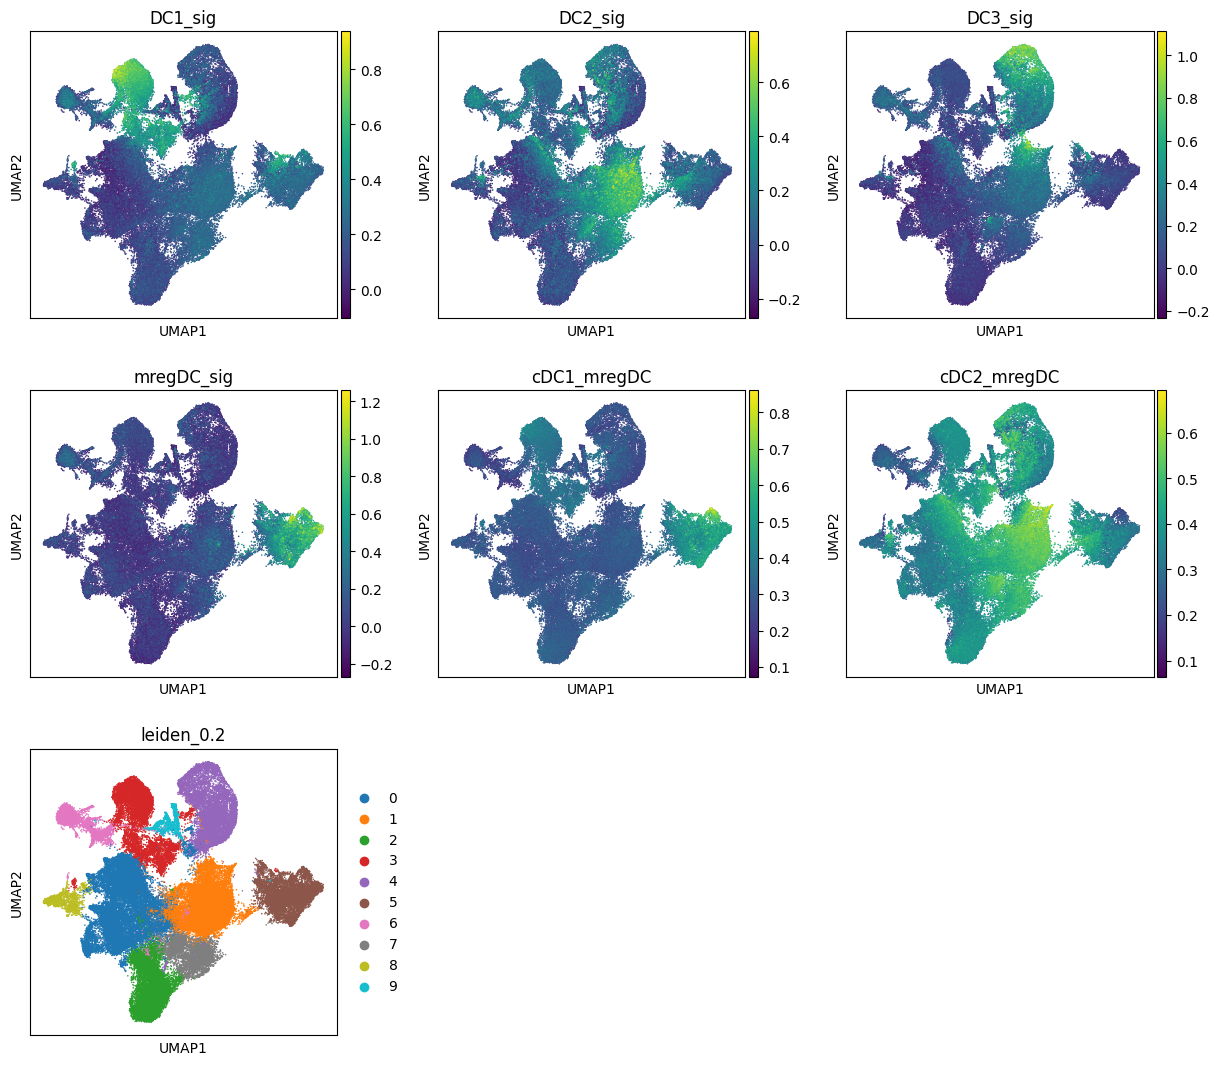

In [31]:
#plotting 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=colour_vars, ncols=3, size=5)

# annotate clusters

In [33]:
data.obs["NR_annotations"] = data.obs["leiden_0.2"].map(
    {
        "0": "cluster 0",
        "1": "cDC2? c1",
        "2": "pDC",
        "3": "cDC1",
        "4": "monocytes",
        "5": "mregDC",
        "6": "cluster 6",
        "7": "cDC2? c2",
        "8": "cluster 8",
        "9": "cluster 9",
    }
)

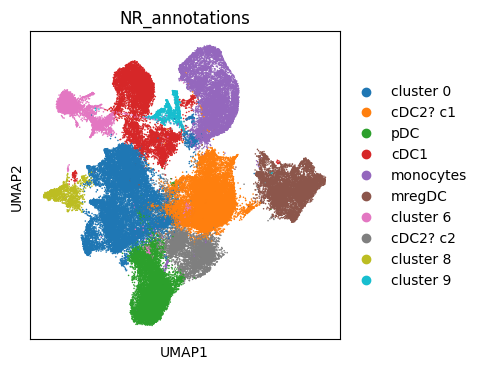

In [36]:
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data, color=["NR_annotations"], size=5)

# plot proportions of clusters

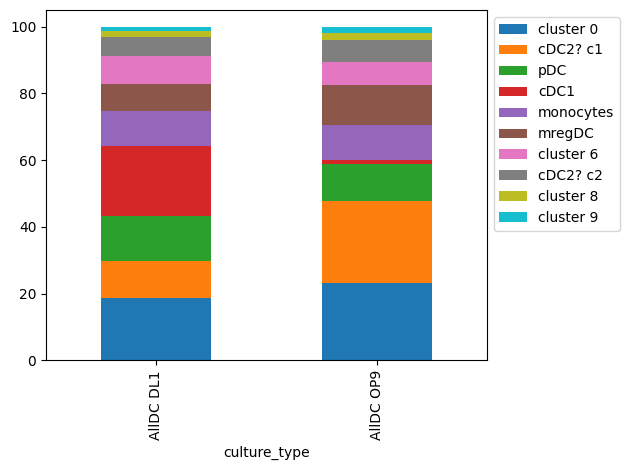

In [47]:
# Create the stacked bar plot 
ax = pd.crosstab(data.obs["culture_type"], data.obs["NR_annotations"]).apply(
    lambda r: r / r.sum() * 100, axis=1
).plot.bar(stacked=True, legend=True)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Moves the legend outside the plot
plt.tight_layout()  
plt.show()

# export DEG genes

In [48]:
#calculate DEG genes:
sc.tl.rank_genes_groups(data, groupby="NR_annotations", method="wilcoxon")

categories: 0, 1, 2, etc.
var_group_labels: cluster 0, cDC2? c1, pDC, etc.


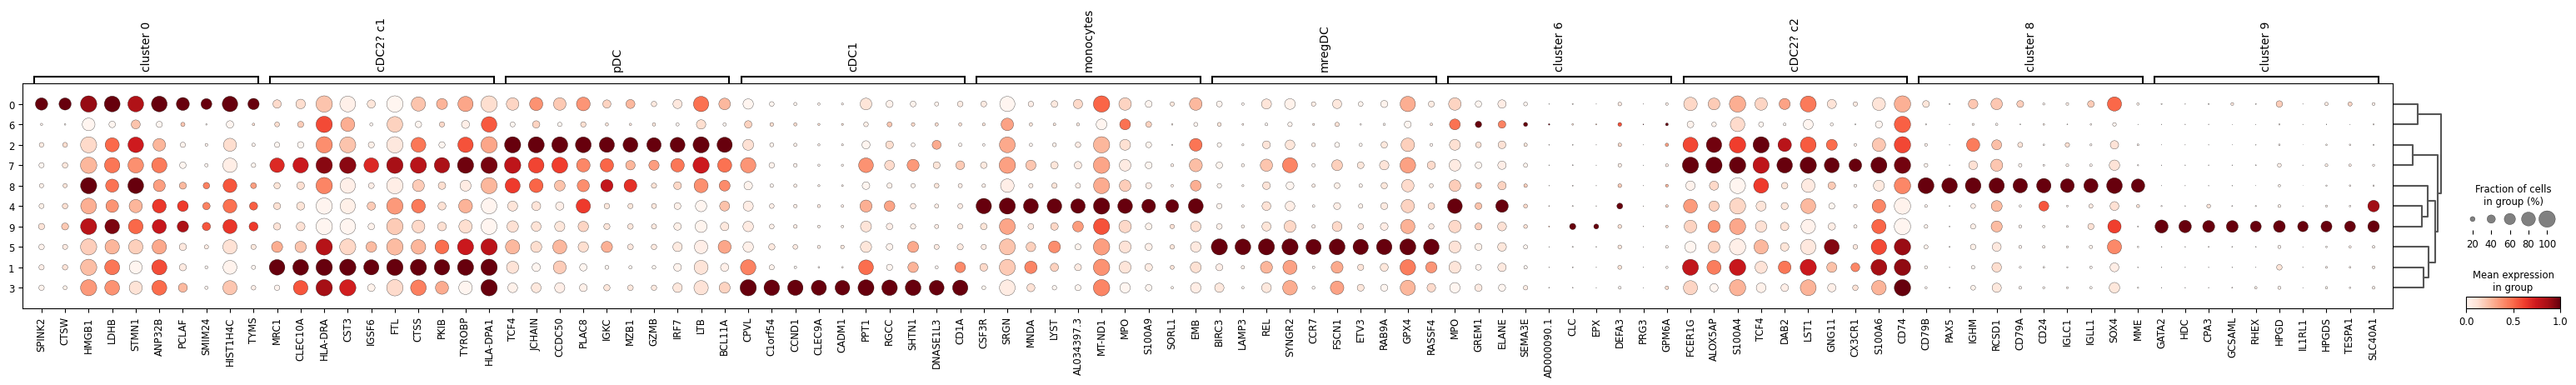

In [49]:
#visualise the top 10 DEG genes for each cluster
sc.pl.rank_genes_groups_dotplot(
    data, groupby="leiden_0.2", standard_scale="var", n_genes=10, min_logfoldchange=1
)

In [53]:
# Get the top 50 genes for each group
top_50_genes = pd.DataFrame({
    group: data.uns['rank_genes_groups']['names'][group][:50]
    for group in data.uns['rank_genes_groups']['names'].dtype.names
})

In [54]:
# Export to CSV
top_50_genes.to_csv("AllDC_DEGs.csv", index=False)
